In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa, os, cv2, pickle, tqdm, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [ ]:
emo = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/EMODB_OpenSMILE_Features.csv')
sav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/SAVEE_OpenSMILE_Features.csv')
rav = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/RAVDESS_OpenSMILE_Features.csv')
iem = pd.read_csv('/content/drive/MyDrive/PBL_2_Files/IEMOCAP_OpenSMILE_Features_2.csv')

In [ ]:
print("EMODB SHAPE =",emo.shape)
print("SAVEE SHAPE =",sav.shape)
print("RAVDESS SHAPE =",rav.shape)
print("IEMOCAP SHAPE =",iem.shape)

EMODB SHAPE = (535, 6374)
SAVEE SHAPE = (480, 6374)
RAVDESS SHAPE = (1440, 6374)
IEMOCAP SHAPE = (7529, 6374)


In [ ]:
def split_preprocess(df,apply_smote=False,rs=536,returnscaler=False):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  if returnscaler:
    return trainX, testX, trainY, testY, scaler
  return trainX, testX, trainY, testY

In [ ]:
trainX, testX, trainY, testY, scaler = split_preprocess(emo,rs=710,returnscaler=True)
le = LabelEncoder()
trainY_enc = le.fit_transform(trainY)
le.classes_

array(['angry', 'boredom', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [ ]:
import pickle
with open('/content/drive/MyDrive/PBL_2_Files/Models/scalerLE_for_ann_model_val_acc_97.20_emodb_opensmile.pkl', 'wb') as f:
  pickle.dump((scaler,le), f)

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


# **Training models on EMO-DB Dataset**

In [ ]:
trainX, testX, trainY, testY = split_preprocess(emo,apply_smote=True)
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(trainX.shape[1],),kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(40, activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                     │ (None, 20)                  │         127,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 40)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 80)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 7)                   │             567 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,167 (516.28 KB)

 Trainable params: 132,167 (516.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=32, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_{accuracy*100:.2f}_emodb_opensmile.keras"
shutil.move(mpath, new_mpath)

Epoch 1/300
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1679 - loss: 2.7139
Epoch 1: val_accuracy improved from -inf to 0.55140, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1945 - loss: 2.6817 - val_accuracy: 0.5514 - val_loss: 1.9342
Epoch 2/300
16/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3974 - loss: 2.3233
Epoch 2: val_accuracy improved from 0.55140 to 0.72897, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4028 - loss: 2.3068 - val_accuracy: 0.7290 - val_loss: 1.5630
Epoch 3/300
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5112 - loss: 2.0000
Epoch 3: val_accuracy improved from 0.72897 to 0.79439, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5142 - l

'/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_val_acc_91.59_emodb_opensmile.keras'

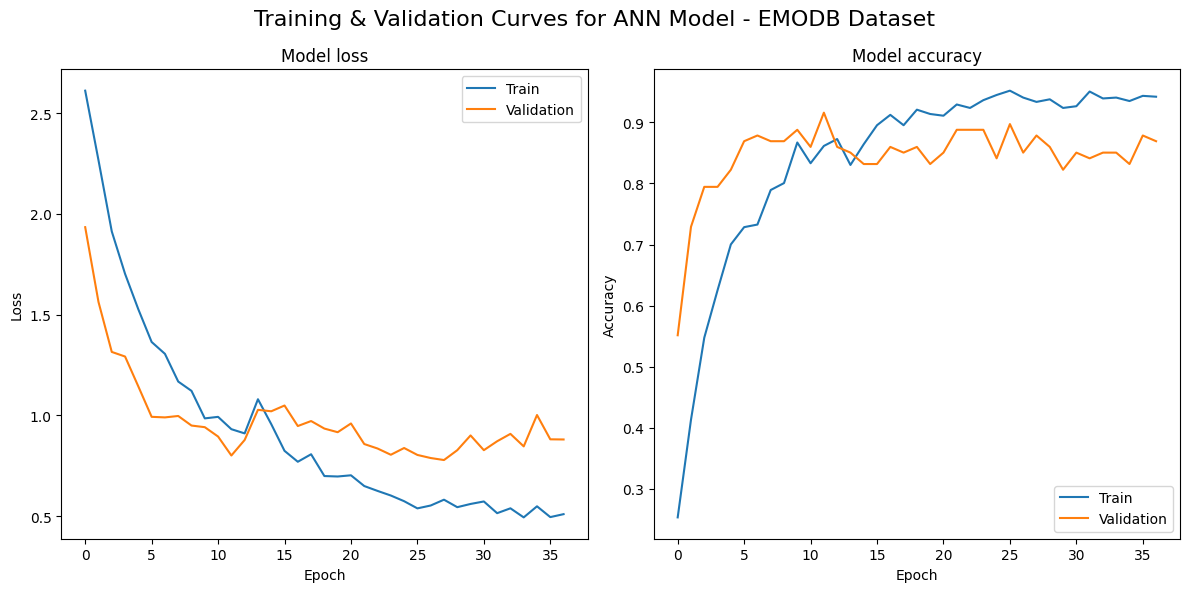

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for ANN Model - EMODB Dataset', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
trainX, testX, trainY, testY = split_preprocess(emo,apply_smote=True,rs=710)
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(trainX.shape[1],),kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(40, activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                     │ (None, 20)                  │         127,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 40)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 80)                  │           3,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 7)                   │             567 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,167 (516.28 KB)

 Trainable params: 132,167 (516.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=32, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_{accuracy*100:.2f}_emodb_opensmile.keras"
shutil.move(mpath, new_mpath)

Epoch 1/300
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2192 - loss: 2.6681
Epoch 1: val_accuracy improved from -inf to 0.57944, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2219 - loss: 2.6649 - val_accuracy: 0.5794 - val_loss: 2.0237
Epoch 2/300
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4428 - loss: 2.2960
Epoch 2: val_accuracy improved from 0.57944 to 0.66355, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4436 - loss: 2.2887 - val_accuracy: 0.6636 - val_loss: 1.6464
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5325 - loss: 1.9436
Epoch 3: val_accuracy improved from 0.66355 to 0.77570, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5333 - 

'/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_93.46_emodb_opensmile.keras'

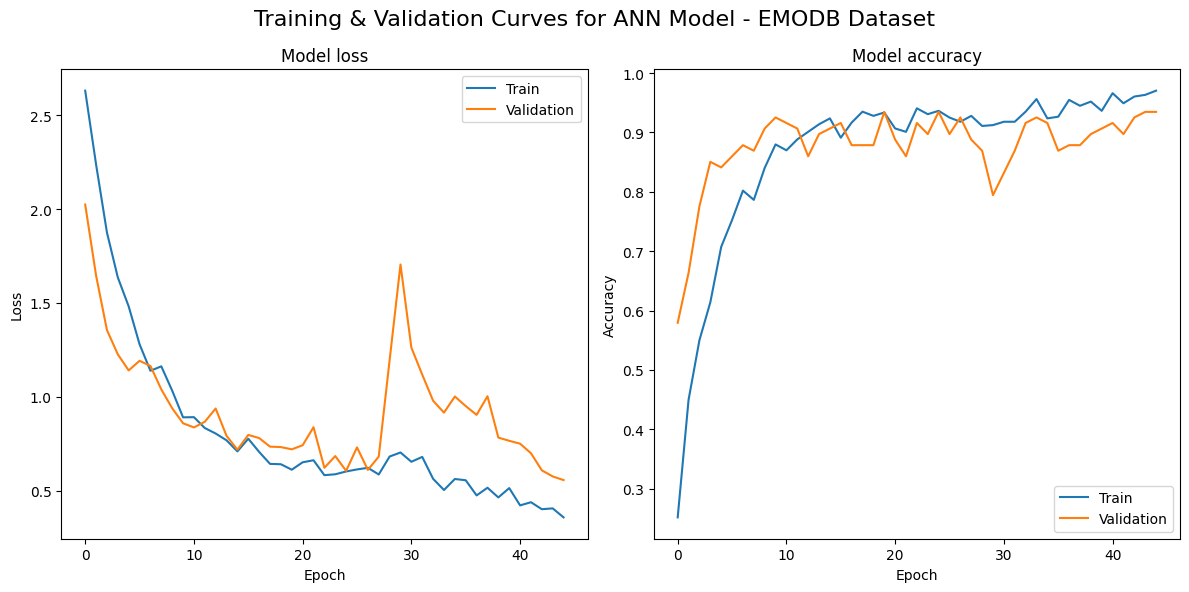

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for ANN Model - EMODB Dataset', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=128, step=2),
                    activation='relu', input_shape=(trainX.shape[1],)))
    model.add(Dropout(hp.Float('dropout_rate_input', min_value=0.2, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=2),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(),'SGD': SGD(),'RMSprop': RMSprop(),'Adadelta': Adadelta(),
                      'Adagrad': Adagrad(),'Adamax': Adamax(),'Nadam': Nadam()}
    selected_optimizer = hp.Choice('optimizer', list(optimizer_dict.keys()))
    model.compile(optimizer=optimizer_dict[selected_optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='ann_hyperparam_tuning',
    project_name='ANN_EMODB3'
)
callbackshpt = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
                #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001)]
tuner.search(trainX, trainY_enc, epochs=500, batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [i for i in range(16,68,4)]),validation_data=(testX, testY_enc),callbacks=callbackshpt)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best trial ID: {best_trial.trial_id}")

Trial 10 Complete [00h 00m 52s]
val_accuracy: 0.9252336621284485

Best val_accuracy So Far: 0.9626168012619019
Total elapsed time: 00h 10m 06s
Best hyperparameters: {'units_input': 68, 'dropout_rate_input': 0.30000000000000004, 'num_layers': 2, 'units_0': 20, 'dropout_rate_0': 0.4, 'optimizer': 'Adamax', 'batch_size': 44, 'units_1': 16, 'dropout_rate_1': 0.4, 'units_2': 120, 'dropout_rate_2': 0.4}
Best trial ID: 03


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 68)                  │         433,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 68)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 435,267 (1.66 MB)

 Trainable params: 435,267 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model.save('/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_val_acc_96.26_emodb_opensmile.keras')

In [ ]:
trainX, testX, trainY, testY = split_preprocess(emo,rs=710)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(trainX.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                     │ (None, 64)                  │         407,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,663 (1.57 MB)

 Trainable params: 410,663 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
             #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=44, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_{accuracy*100:.2f}_emodb_opensmile.keras"
shutil.move(mpath, new_mpath)

Epoch 1/300
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1894 - loss: 2.3693
Epoch 1: val_accuracy improved from -inf to 0.41121, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.2077 - loss: 2.3414 - val_accuracy: 0.4112 - val_loss: 1.4787
Epoch 2/300
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2972 - loss: 1.7567
Epoch 2: val_accuracy improved from 0.41121 to 0.59813, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3256 - loss: 1.7486 - val_accuracy: 0.5981 - val_loss: 1.2083
Epoch 3/300
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5394 - loss: 1.4277
Epoch 3: val_accuracy improved from 0.59813 to 0.71963, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5380 -

'/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_94.39_emodb_opensmile.keras'

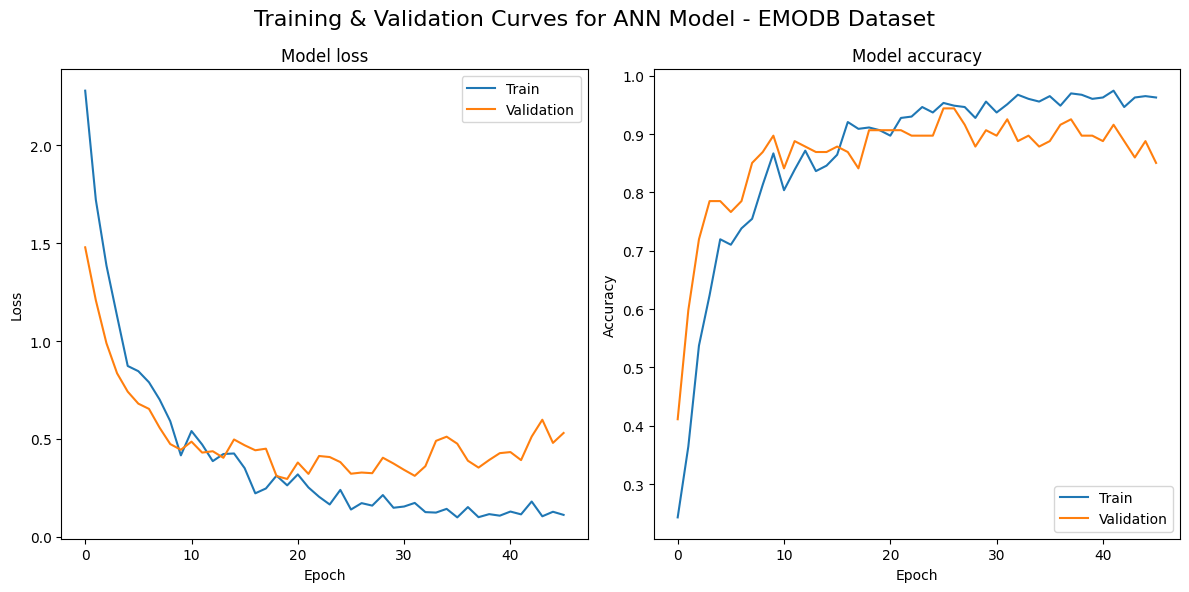

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for ANN Model - EMODB Dataset', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
trainX, testX, trainY, testY = split_preprocess(emo,rs=710)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(trainX.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                     │ (None, 64)                  │         407,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,663 (1.57 MB)

 Trainable params: 410,663 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
             #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=44, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_{accuracy*100:.2f}_emodb_opensmile.keras"
shutil.move(mpath, new_mpath)

Epoch 1/300
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1654 - loss: 2.0584
Epoch 1: val_accuracy improved from -inf to 0.56075, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2116 - loss: 2.0272 - val_accuracy: 0.5607 - val_loss: 1.3248
Epoch 2/300
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3942 - loss: 1.4676
Epoch 2: val_accuracy improved from 0.56075 to 0.65421, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4227 - loss: 1.4613 - val_accuracy: 0.6542 - val_loss: 1.0305
Epoch 3/300
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5054 - loss: 1.3285
Epoch 3: val_accuracy improved from 0.65421 to 0.74766, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_emodb_opensmile.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5305 -

'/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_97.20_emodb_opensmile.keras'

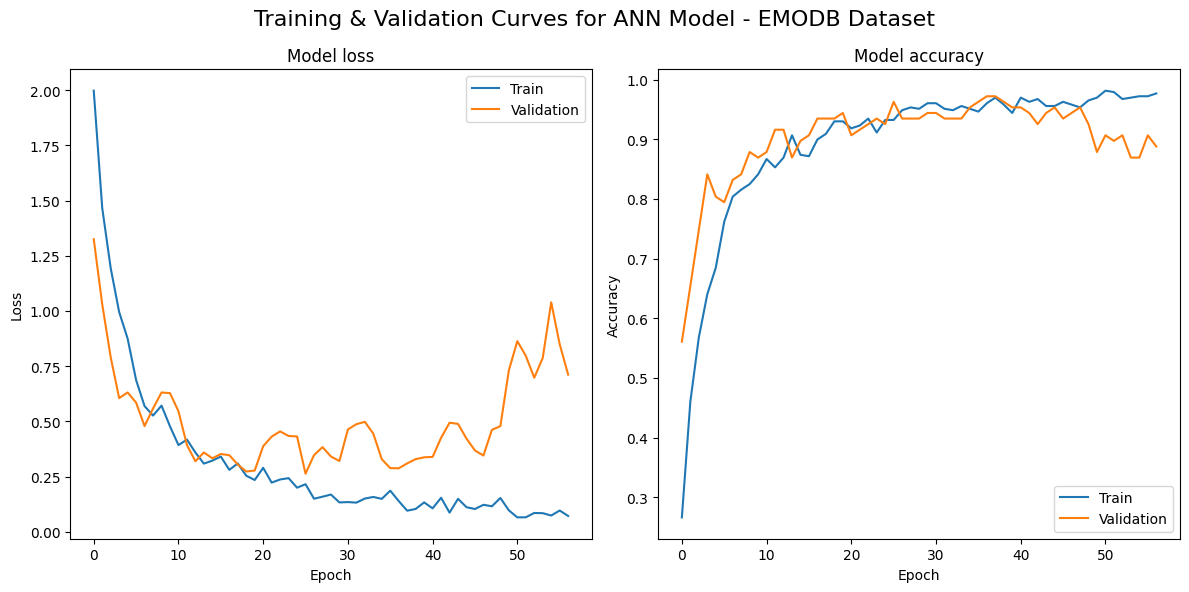

In [ ]:
# Model saved at epoch 37
plt.figure(figsize=(12, 6))
plt.suptitle('Training & Validation Curves for ANN Model - EMODB Dataset', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

# **Training models on RAVDESS Dataset**

In [ ]:
def plot_history(hist,data):
  plt.figure(figsize=(12, 6))
  plt.suptitle(f'Training & Validation Curves for ANN Model - {data} Dataset', fontsize=16)
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.tight_layout()
  plt.show()

In [ ]:
trainX, testX, trainY, testY = split_preprocess(rav,rs=200)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(trainX.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │         407,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,680 (1.57 MB)

 Trainable params: 410,680 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
             #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=300, batch_size=44, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_{accuracy*100:.2f}_ravdess_opensmile.keras"
shutil.move(mpath, new_mpath)

Epoch 1/300
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1553 - loss: 2.5220
Epoch 1: val_accuracy improved from -inf to 0.37847, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.1583 - loss: 2.5146 - val_accuracy: 0.3785 - val_loss: 1.7102
Epoch 2/300
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2989 - loss: 2.0327
Epoch 2: val_accuracy improved from 0.37847 to 0.43403, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3007 - loss: 2.0240 - val_accuracy: 0.4340 - val_loss: 1.5681
Epoch 3/300
24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3672 - loss: 1.7155
Epoch 3: val_accuracy improved from 0.43403 to 0.50347, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.

'/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_79.86_ravdess_opensmile.keras'

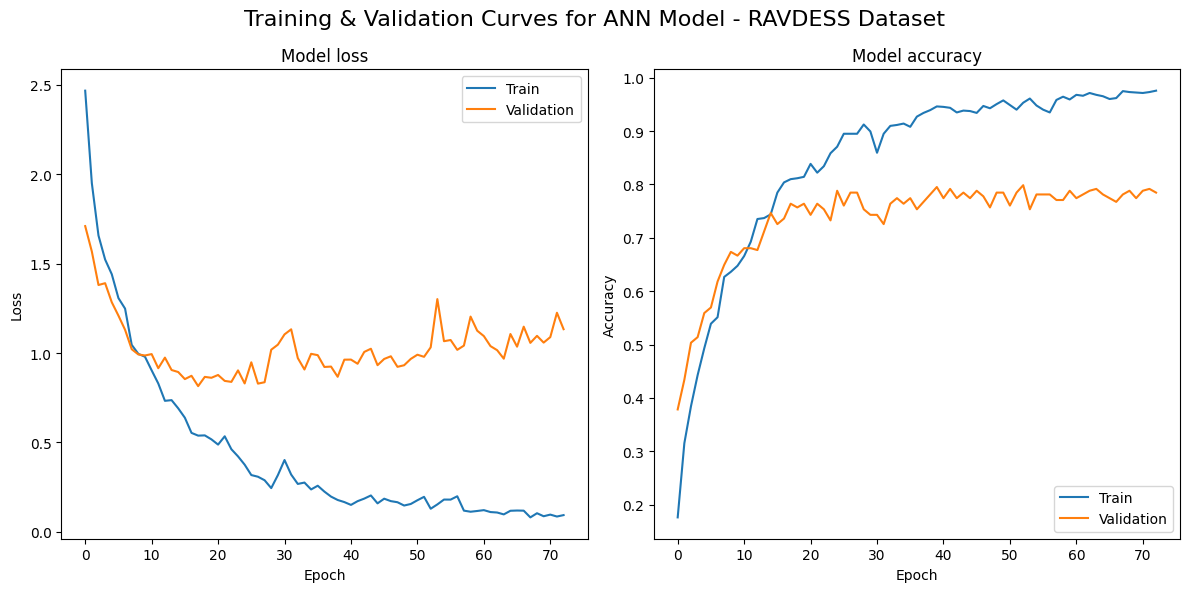

In [ ]:
plot_history(history,'RAVDESS')

In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
def build_model(hp):
    model = Sequential()
    reg = hp.Choice('regularizer', ['l2', 'l1', 'l1_l2', 'none'])
    if reg == 'l2':
        kr = regularizers.l2(0.001)
    elif reg == 'l1':
        kr = regularizers.l1(0.001)
    elif reg == 'l1_l2':
        kr = regularizers.l1_l2(l1=0.001, l2=0.001)
    else:
        kr = None
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=128, step=2),
                    activation='relu', input_shape=(trainX.shape[1],),
                    kernel_regularizer=kr))
    model.add(Dropout(hp.Float('dropout_rate_input', min_value=0, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=2),
                        activation='relu', kernel_regularizer=kr))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    lr = hp.Float('learning_rate',min_value=0.00001,max_value=0.01,step=0.00001)
    optimizer_dict = {'Adam': Adam(learning_rate=lr),'SGD': SGD(learning_rate=lr),'RMSprop': RMSprop(learning_rate=lr),
                      'Adadelta': Adadelta(learning_rate=lr),'Adagrad': Adagrad(learning_rate=lr),'Adamax': Adamax(learning_rate=lr),
                      'Nadam': Nadam(learning_rate=lr)}
    selected_optimizer = hp.Choice('optimizer', list(optimizer_dict.keys()))
    model.compile(optimizer=optimizer_dict[selected_optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='ann_hyperparam_tuning',
    project_name='ANN_RAVDESS6'
)
callbackshpt = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001)]
tuner.search(trainX, trainY_enc, epochs=500, batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [i for i in range(16,132,4)]),validation_data=(testX, testY_enc),callbacks=callbackshpt)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best trial ID: {best_trial.trial_id}")

Trial 10 Complete [00h 02m 04s]
val_accuracy: 0.7048611044883728

Best val_accuracy So Far: 0.8368055820465088
Total elapsed time: 00h 19m 59s
Best hyperparameters: {'regularizer': 'none', 'units_input': 72, 'dropout_rate_input': 0.30000000000000004, 'num_layers': 3, 'units_0': 52, 'dropout_rate_0': 0.0, 'learning_rate': 0.00496, 'optimizer': 'Adamax', 'batch_size': 48, 'units_1': 122, 'dropout_rate_1': 0.2, 'units_2': 92, 'dropout_rate_2': 0.1}
Best trial ID: 05


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 72)                  │         458,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 72)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 52)                  │           3,796 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 52)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 122)                 │           6,466 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 122)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 92)                  │          11,316 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 92)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             744 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,250 (1.84 MB)

 Trainable params: 481,250 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model.save('/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_val_acc_83.68_ravdess_opensmile.keras')

In [ ]:
trials_data = []
for trial in tuner.oracle.trials.values():
    trial_hps = trial.hyperparameters.values.copy()
    val_acc = trial.metrics.get_best_value('val_accuracy')
    trial_hps['val_accuracy'] = val_acc
    trials_data.append(trial_hps)
trials_df = pd.DataFrame(trials_data)
accuracy_column = trials_df.pop('val_accuracy')
trials_df['val_accuracy'] = accuracy_column
trials_df.sort_values(by='val_accuracy', ascending=False, inplace=True)
trials_df

,regularizer,units_input,dropout_rate_input,num_layers,units_0,dropout_rate_0,learning_rate,optimizer,batch_size,units_1,dropout_rate_1,units_2,dropout_rate_2,val_accuracy
5,none,72,0.3,3,52,0.0,0.00496,Adamax,48,122,0.2,92,0.1,0.836806
0,l1,116,0.3,3,78,0.2,0.00750,Adagrad,76,16,0.0,16,0.0,0.805556
3,l1,40,0.4,1,66,0.3,0.00528,Adam,128,98,0.0,20,0.3,0.798611
4,l2,64,0.1,2,58,0.1,0.00403,Nadam,28,54,0.4,110,0.4,0.791667
6,l1,28,0.4,2,92,0.1,0.00669,Adamax,72,68,0.0,70,0.1,0.791667
1,l1,80,0.4,2,54,0.1,0.00388,Nadam,72,60,0.1,44,0.4,0.770833
2,l1,110,0.0,2,40,0.2,0.00416,RMSprop,96,84,0.4,34,0.3,0.739583
8,l1,80,0.4,2,54,0.4,0.00845,Adam,28,80,0.2,54,0.0,0.722222
9,l1,44,0.1,2,60,0.1,0.00815,Adam,104,42,0.3,60,0.3,0.704861
7,l1,64,0.2,2,58,0.4,0.00816,Adam,72,42,0.0,70,0.1,0.680556


In [ ]:
df_analysis = trials_df.copy()
opt = LabelEncoder()
for column in df_analysis.columns:
  if df_analysis[column].dtype == object:
    df_analysis[column] = opt.fit_transform(df_analysis[column])
correlations = df_analysis.corr()['val_accuracy']
correlations = correlations.drop('val_accuracy')
print(correlations.sort_values(ascending=False))

regularizer           0.566860
units_1               0.373819
dropout_rate_input    0.365085
units_0               0.314019
num_layers            0.310562
optimizer             0.095188
units_2               0.053506
units_input           0.031341
dropout_rate_2        0.004924
batch_size           -0.104122
dropout_rate_1       -0.133716
learning_rate        -0.539634
dropout_rate_0       -0.589309
Name: val_accuracy, dtype: float64


In [ ]:
pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model #1


Input Units = 125, dropout_rate_input = 0.206101206673668
hidden_units_and_dropout = [(120, 0.11172706169202978), (71, 0.1410158289916017), (119, 0.26084183886019047)]
learning_rate = 0.004964299579109196, optimizer_choice = Adagrad
batch_size = 28, UsedAdpLR = True

Training time: 1 min 54 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8136 - loss: 0.6504 

Accuracy: 80.56
New Best Accuracy!


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_711 (Dense)                    │ (None, 125)                 │         796,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_362 (Activation)          │ (None, 125)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_448              │ (None, 125)                 │             500 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_552 (Dropout)                │ (None, 125)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_712 (Dense)                    │ (None, 120)                 │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_449              │ (None, 120)                 │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_363 (Activation)          │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_553 (Dropout)                │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_713 (Dense)                    │ (None, 71)                  │           8,591 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_450              │ (None, 71)                  │             284 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_364 (Activation)          │ (None, 71)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_554 (Dropout)                │ (None, 71)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_714 (Dense)                    │ (None, 119)                 │           8,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_451              │ (None, 119)                 │             476 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_365 (Activation)          │ (None, 119)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_555 (Dropout)                │ (None, 119)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_715 (Dense)                    │ (None, 8)                   │             960 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,662,590 (6.34 MB)

 Trainable params: 830,859 (3.17 MB)

 Non-trainable params: 870 (3.40 KB)

 Optimizer params: 830,861 (3.17 MB)

None 



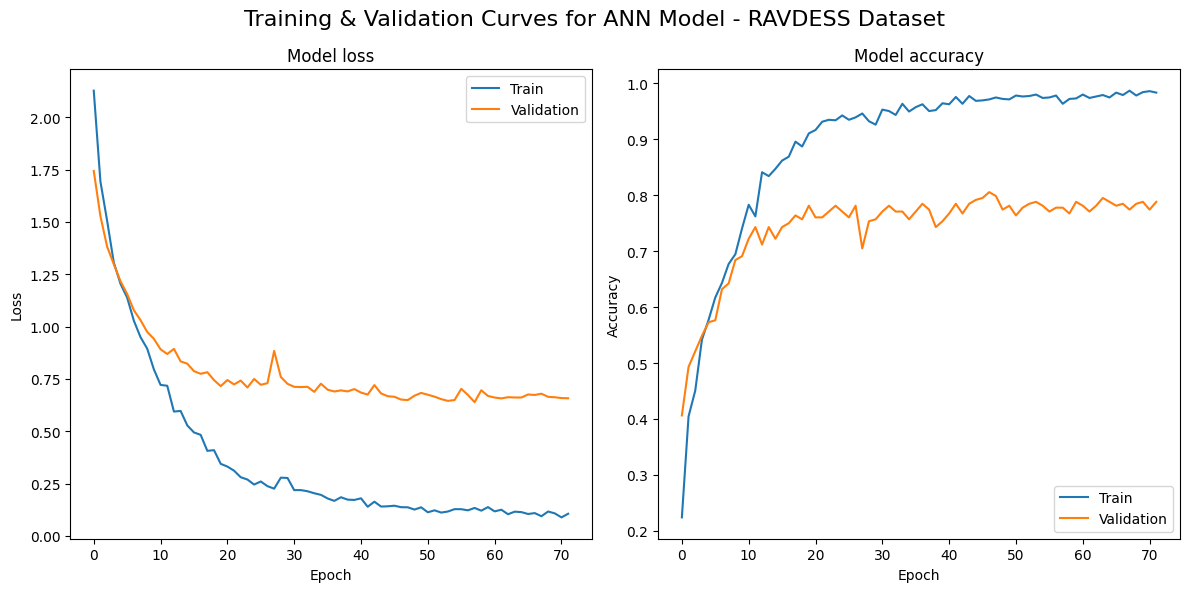

Training model #2


Input Units = 53, dropout_rate_input = 0.2660003497033556
hidden_units_and_dropout = [(59, 0.4446779302951047), (79, 0.1183999462719112), (49, 0.39838397446253326)]
learning_rate = 0.0014251768351578465, optimizer_choice = Adagrad
batch_size = 60, UsedAdpLR = True

Training time: 1 min 33 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6303 - loss: 1.3119 

Accuracy: 62.85
Training model #3


Input Units = 39, dropout_rate_input = 0.16918349657748188
hidden_units_and_dropout = [(84, 0.07133210722617378), (51, 0.31514809406057676), (42, 0.46062366112421277)]
learning_rate = 0.0033743881212150773, optimizer_choice = Adam
batch_size = 95, UsedAdpLR = True

Training time: 0 min 27 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8005 - loss: 0.8296 

Accuracy: 79.17
Training model #4


Input Units = 48, dropout_rate_input = 0.0072324239895185105
hidden_units_and_dropout = [(29, 0.1636433015836829), (38, 0.4450182716548269), (44, 0.37428690906503176)]
learni

Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_746 (Dense)                    │ (None, 85)                  │         541,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_390 (Activation)          │ (None, 85)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_476              │ (None, 85)                  │             340 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_580 (Dropout)                │ (None, 85)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_747 (Dense)                    │ (None, 104)                 │           8,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_477              │ (None, 104)                 │             416 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_391 (Activation)          │ (None, 104)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_581 (Dropout)                │ (None, 104)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_748 (Dense)                    │ (None, 47)                  │           4,935 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_478              │ (None, 47)                  │             188 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_392 (Activation)          │ (None, 47)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_582 (Dropout)                │ (None, 47)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_749 (Dense)                    │ (None, 115)                 │           5,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_479              │ (None, 115)                 │             460 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_393 (Activation)          │ (None, 115)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_583 (Dropout)                │ (None, 115)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_750 (Dense)                    │ (None, 8)                   │             928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,689,161 (6.44 MB)

 Trainable params: 562,819 (2.15 MB)

 Non-trainable params: 702 (2.74 KB)

 Optimizer params: 1,125,640 (4.29 MB)

None 



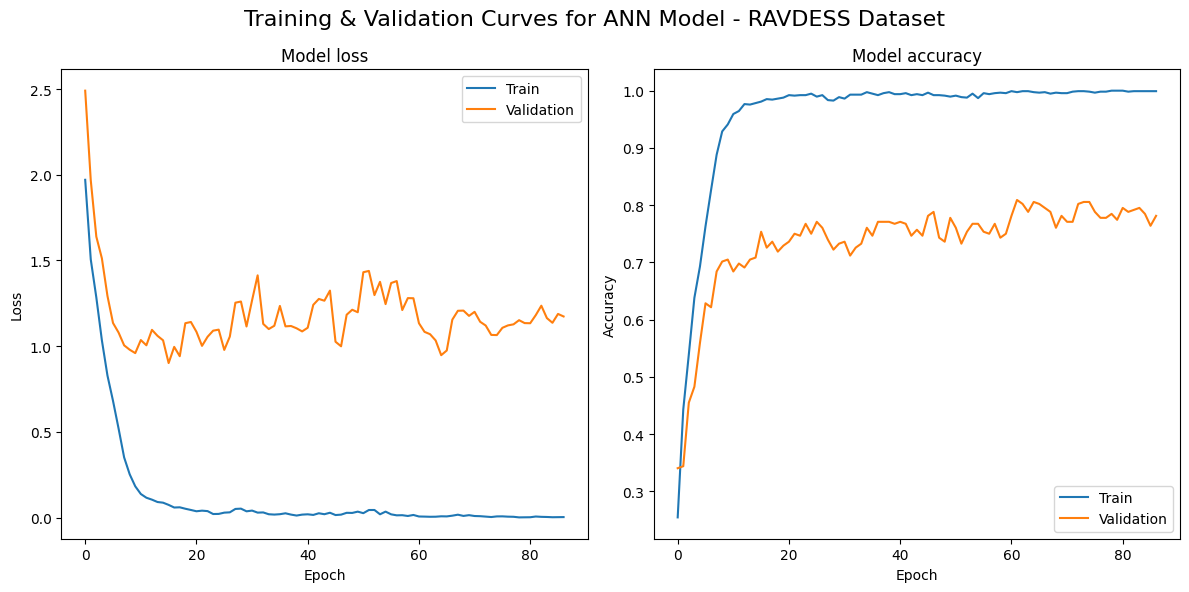

Training model #9


Input Units = 25, dropout_rate_input = 0.03274328875169763
hidden_units_and_dropout = [(98, 0.0622675025995475), (57, 0.19958259922048083), (17, 0.19458819971094554)]
learning_rate = 0.0019473347756650806, optimizer_choice = RMSprop
batch_size = 87, UsedAdpLR = False

Training time: 0 min 24 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7954 - loss: 1.1073 

Accuracy: 78.82
Training model #10


Input Units = 108, dropout_rate_input = 0.42285851261340657
hidden_units_and_dropout = [(100, 0.09131512786883761), (115, 0.27611868947689416), (25, 0.17010133211111617)]
learning_rate = 0.003185162854001661, optimizer_choice = Nadam
batch_size = 17, UsedAdpLR = True

Training time: 2 min 40 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8268 - loss: 0.6603 

Accuracy: 81.60
New Best Accuracy!


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)                    │ (None, 108)                 │         688,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_398 (Activation)          │ (None, 108)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_484              │ (None, 108)                 │             432 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_588 (Dropout)                │ (None, 108)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_757 (Dense)                    │ (None, 100)                 │          10,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_485              │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_399 (Activation)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_589 (Dropout)                │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_758 (Dense)                    │ (None, 115)                 │          11,615 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_486              │ (None, 115)                 │             460 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_400 (Activation)          │ (None, 115)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_590 (Dropout)                │ (None, 115)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_759 (Dense)                    │ (None, 25)                  │           2,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_487              │ (None, 25)                  │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_401 (Activation)          │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_591 (Dropout)                │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_760 (Dense)                    │ (None, 8)                   │             208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,144,832 (8.18 MB)

 Trainable params: 714,711 (2.73 MB)

 Non-trainable params: 696 (2.72 KB)

 Optimizer params: 1,429,425 (5.45 MB)

None 



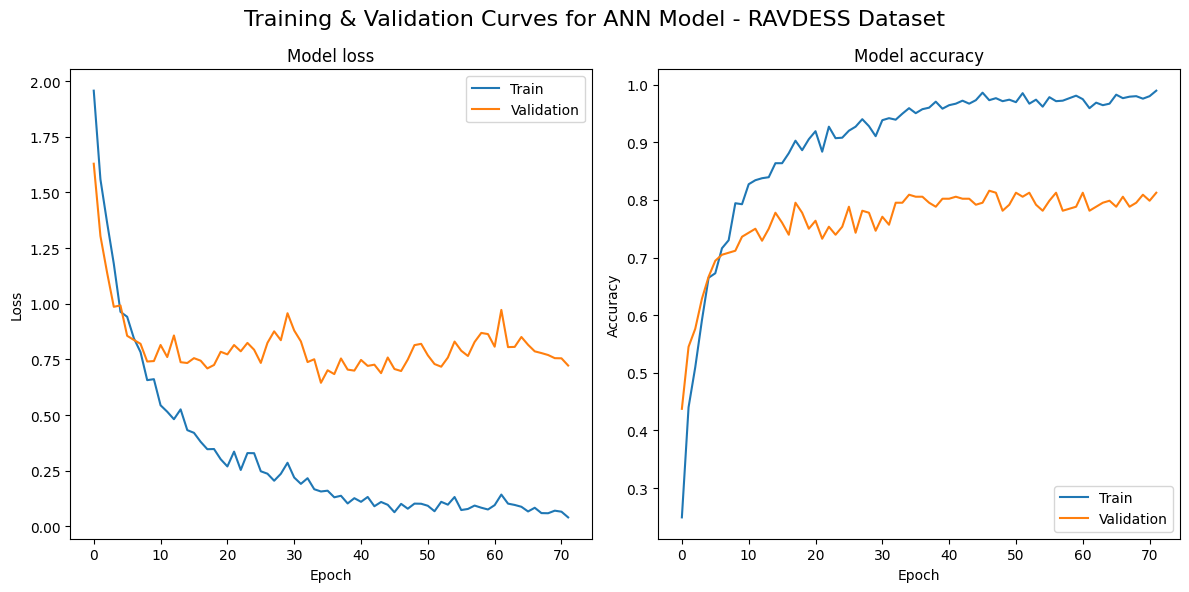

gen	nevals	avg    	max     
0  	10    	0.69375	0.815972
1 0.206101206673668 0.42285851261340657
3 0.004964299579109196 0.003185162854001661
1 0.42285851261340657 0.37854716401966
3 0.003185162854001661 0.0013918307537793388
Training model #11


Input Units = 119, dropout_rate_input = 0.45001765668958005
hidden_units_and_dropout = [(116, 0.10798885645948492), (70, 0.1373347834666686), (128, 0.2737582609597054)]
learning_rate = 0.005, optimizer_choice = Nadam
batch_size = 18, UsedAdpLR = True

Training time: 2 min 32 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8211 - loss: 0.7437  

Accuracy: 83.33
New Best Accuracy!


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_761 (Dense)                    │ (None, 119)                 │         758,506 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_402 (Activation)          │ (None, 119)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_488              │ (None, 119)                 │             476 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_592 (Dropout)                │ (None, 119)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_762 (Dense)                    │ (None, 116)                 │          13,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_489              │ (None, 116)                 │             464 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_403 (Activation)          │ (None, 116)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_593 (Dropout)                │ (None, 116)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_763 (Dense)                    │ (None, 70)                  │           8,190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_490              │ (None, 70)                  │             280 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_404 (Activation)          │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_594 (Dropout)                │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_764 (Dense)                    │ (None, 128)                 │           9,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_491              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_405 (Activation)          │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_595 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_765 (Dense)                    │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,375,675 (9.06 MB)

 Trainable params: 791,602 (3.02 MB)

 Non-trainable params: 866 (3.38 KB)

 Optimizer params: 1,583,207 (6.04 MB)

None 



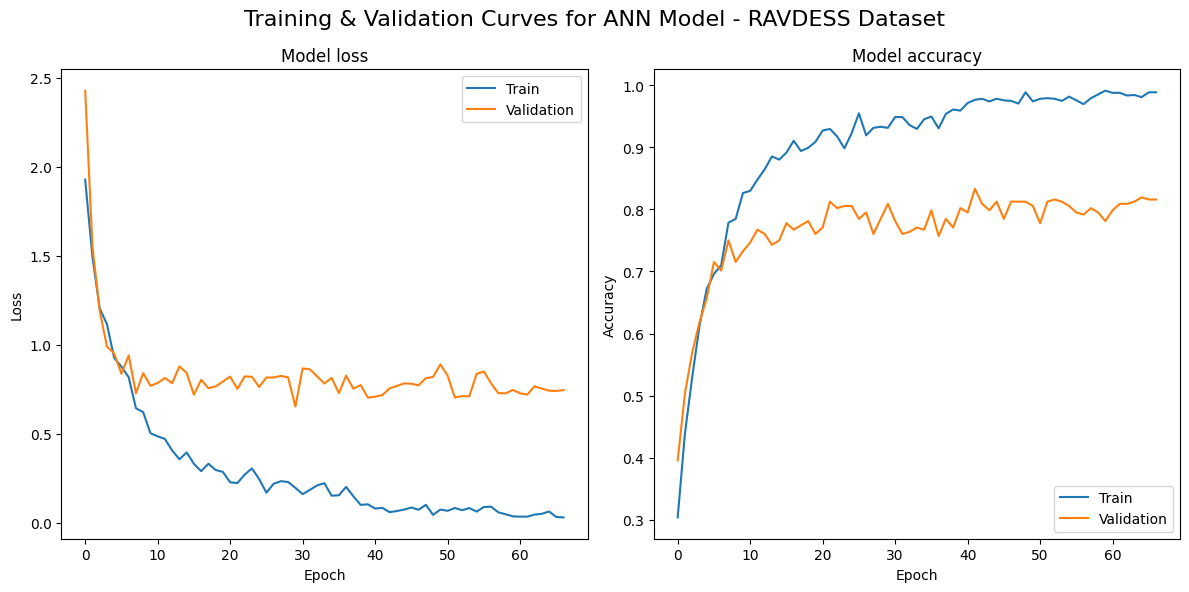

Training model #12


Input Units = 114, dropout_rate_input = 0.17894206259749457
hidden_units_and_dropout = [(128, 0.2737582609597054), (70, 0.1373347834666686), (116, 0.10798885645948492)]
learning_rate = 0.0030912839735637377, optimizer_choice = Nadam
batch_size = 27, UsedAdpLR = True

Training time: 2 min 39 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8258 - loss: 0.9711

Accuracy: 81.94
Training model #13


Input Units = 85, dropout_rate_input = 0.008796617586829925
hidden_units_and_dropout = [(104, 0.30399306396152687), (47, 0.20741855934012027), (115, 0.01909932871490405)]
learning_rate = 0.0032902962435019567, optimizer_choice = Adam
batch_size = 118, UsedAdpLR = False

Training time: 0 min 18 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7879 - loss: 0.8027 

Accuracy: 79.17
Training model #14


Input Units = 133, dropout_rate_input = 0.3628364978758021
hidden_units_and_dropout = [(70, 0.03611151783766216), (128, 0.3335300847845798), (119, 0.4584294694464571

Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_881 (Dense)                    │ (None, 108)                 │         688,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_498 (Activation)          │ (None, 108)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_584              │ (None, 108)                 │             432 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_688 (Dropout)                │ (None, 108)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_882 (Dense)                    │ (None, 100)                 │          10,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_585              │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_499 (Activation)          │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_689 (Dropout)                │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_883 (Dense)                    │ (None, 113)                 │          11,413 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_586              │ (None, 113)                 │             452 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_500 (Activation)          │ (None, 113)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_690 (Dropout)                │ (None, 113)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_884 (Dense)                    │ (None, 23)                  │           2,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_587              │ (None, 23)                  │              92 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_501 (Activation)          │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_691 (Dropout)                │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_885 (Dense)                    │ (None, 8)                   │             192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143,312 (8.18 MB)

 Trainable params: 714,207 (2.72 MB)

 Non-trainable params: 688 (2.69 KB)

 Optimizer params: 1,428,417 (5.45 MB)

None 



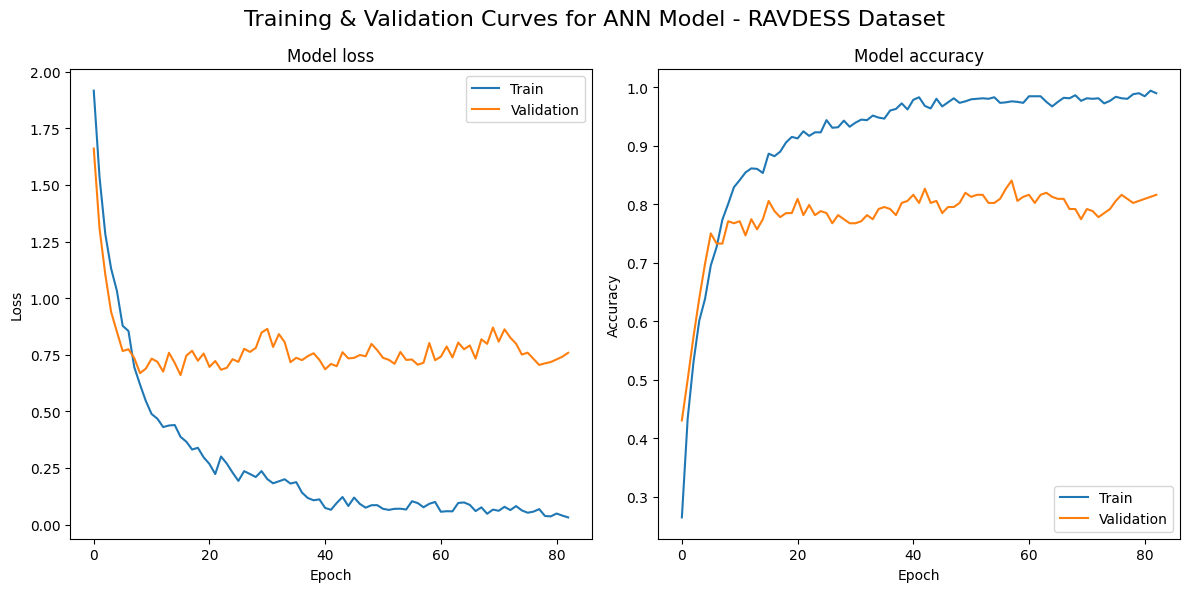

4  	6     	0.753472	0.840278
1 0.42285851261340657 0.4483867224637591
3 0.003185162854001661 0.003109064517108633
1 0.42285851261340657 0.08239243570193944
3 0.003185162854001661 0.0033079231762126664
1 0.40596706777082114 0.42285851261340657
3 0.003186695516726659 0.003185162854001661
1 0.4483867224637591 0.40596706777082114
3 0.003109064517108633 0.013792071214185485
Training model #36


Input Units = 106, dropout_rate_input = 0.413506818385069
hidden_units_and_dropout = [(121, 0.21018498376162817), (115, 0.2707818979905771), (16, 0.19459917203989185)]
learning_rate = 0.003177743020140033, optimizer_choice = Adagrad
batch_size = 33, UsedAdpLR = True

Training time: 1 min 54 sec
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7177 - loss: 1.0648 

Accuracy: 72.92
Training model #37


Input Units = 107, dropout_rate_input = 0.4577384166920967
hidden_units_and_dropout = [(16, 0.19459917203989185), (115, 0.2707818979905771), (121, 0.21018498376162817)]
learning_rate = 0.00311648435097

In [ ]:
from deap import base, creator, tools, algorithms
import time
best_accuracy = -np.inf
model_train_count = 0
def custom_cxBlend(ind1, ind2, alpha):
    """Custom crossover function to handle the list of tuples of hidden units and dropout rates."""
    for i, (x1, x2) in enumerate(zip(ind1, ind2)):
        if i == 2:
            new_hidden_units_and_dropout = []
            for (hu1, do1), (hu2, do2) in zip(x1, x2):
                gamma = (1. + 2. * alpha) * np.random.random() - alpha
                new_hu = int(round((1. - gamma) * hu1 + gamma * hu2))
                new_do = (1. - gamma) * do1 + gamma * do2
                new_hidden_units_and_dropout.append((new_hu, new_do))
            ind1[i] = new_hidden_units_and_dropout
            ind2[i] = new_hidden_units_and_dropout[::-1]
        else:
            gamma = (1. + 2. * alpha) * np.random.random() - alpha
            if i in [0, 5]:
                ind1[i] = int(round((1. - gamma) * x1 + gamma * x2))
                ind2[i] = int(round(gamma * x1 + (1. - gamma) * x2))
            elif i in [4, 6]:
                ind1[i] = np.random.choice([x1, x2])
                ind2[i] = np.random.choice([x1, x2])
            else:
                print(i,x1,x2)
                ind1[i] = (1. - gamma) * x1 + gamma * x2
                ind2[i] = gamma * x1 + (1. - gamma) * x2
    return ind1, ind2
optimizers = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
def custom_mutation(individual, indpb):
    """Custom mutation function for an individual with both continuous, categorical and boolean genes."""
    for i, gene in enumerate(individual):
        if isinstance(gene, str) and gene in optimizers:
            if np.random.random() < indpb:
                new_optimizer = np.random.choice([opt for opt in optimizers if opt != gene])
                individual[i] = new_optimizer

        elif i==2:
            new_hu_do = []
            for j, (hu, do) in enumerate(gene):
                if np.random.random() < indpb:
                  new_hu_do.append((int(np.clip(hu + np.random.randint(-5,5), 16, 128)), np.clip(do + np.random.uniform(-0.1,0.1), 0, 0.5)))
                else:
                  new_hu_do.append((hu,do))
            individual[i] = new_hu_do
        elif i in [0,5]:
            if np.random.random() < indpb:
                individual[i] += np.random.randint(-5,5)
        elif isinstance(gene,bool):
          if np.random.random() < indpb:
            individual[i] = not individual[i]
        elif i==1:
          if np.random.random() < indpb:
            individual[i] = np.random.uniform(0,0.5)
        elif i==3:
            if np.random.random() < indpb:
                individual[i] += np.random.normal(0, 0.1)
    return individual,

def evaluate_model(params):
    global best_accuracy
    global model_train_count
    model_train_count += 1
    print(f"Training model #{model_train_count}")
    units_input, dropout_rate_input, hidden_units_and_dropout, learning_rate, optimizer_choice, batch_size,adlr = params
    dropout_rate_input = np.clip(dropout_rate_input, 0, 0.5)
    hidden_units_and_dropout = [(int(np.clip(hu, 16, 128)), np.clip(do, 0, 0.5)) for hu, do in hidden_units_and_dropout]
    learning_rate = np.clip(learning_rate, 1e-5, 5e-3)
    batch_size = int(np.clip(batch_size, 16, 132))
    print()
    print(f"\nInput Units = {units_input}, dropout_rate_input = {dropout_rate_input}")
    print(f"hidden_units_and_dropout = {hidden_units_and_dropout}")
    print(f"learning_rate = {learning_rate}, optimizer_choice = {optimizer_choice}")
    print(f"batch_size = {batch_size}, UsedAdpLR = {adlr}\n")
    model = Sequential()
    model.add(Dense(units=units_input, input_shape=(trainX.shape[1],)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate_input))
    for hidden_units, dropout_rate in hidden_units_and_dropout:
        model.add(Dense(units=hidden_units))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(len(np.unique(trainY)), activation='softmax'))

    optimizer_dict = {
        'Adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'SGD': tf.keras.optimizers.SGD(learning_rate=learning_rate),
        'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        'Adadelta': tf.keras.optimizers.Adadelta(learning_rate=learning_rate),
        'Adagrad': tf.keras.optimizers.Adagrad(learning_rate=learning_rate),
        'Adamax': tf.keras.optimizers.Adamax(learning_rate=learning_rate),
        'Nadam': tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    }
    optimizer = optimizer_dict[optimizer_choice]
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
    if adlr:
      callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001))
    st = time.time()
    history = model.fit(trainX, trainY_enc, epochs=500, batch_size=batch_size,
                        validation_data=(testX, testY_enc),callbacks=callbacks,verbose=0)
    en = time.time()
    tm = en-st
    print(f"Training time: {tm/60:.0f} min {tm%60:.0f} sec")
    _, acc = model.evaluate(testX, testY_enc)
    print('\nAccuracy: %.2f' % (acc*100))
    if acc > best_accuracy:
        print("New Best Accuracy!")
        print(model.summary(),"\n")
        plot_history(history,'RAVDESS')
        best_accuracy = acc
        if acc>0.84:
          model.save(f'/content/drive/MyDrive/PBL_2_Files/Models/ann_model{model_train_count}_GA_val_acc_{acc*100:.2f}_ravdess_opensmile.keras')
    return acc,

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("units_input", np.random.randint, 16, 128)
toolbox.register("dropout_rate_input", np.random.uniform, 0, 0.5)
toolbox.register("hidden_units_and_dropout",
                 tools.initRepeat, list,
                 lambda: (np.random.randint(16, 128), np.random.uniform(0, 0.5)), n=3)
toolbox.register("learning_rate", np.random.uniform, 1e-5, 5e-3)
toolbox.register("optimizer_choice", np.random.choice, ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam'])  # Optimizer choice
toolbox.register("batch_size", np.random.randint,16,132)
toolbox.register("adaptLR",np.random.choice,[True,False])
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.units_input, toolbox.dropout_rate_input,
                  toolbox.hidden_units_and_dropout, toolbox.learning_rate, toolbox.optimizer_choice,toolbox.batch_size,
                  toolbox.adaptLR), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_model)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutation, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=2)

def main():
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5,
                          stats=stats, halloffame=hof, verbose=True)

    return hof

best_individual = main()
print(f"Best individual: {best_individual[0]}")
print(f"Validation accuracy: {best_individual[0].fitness.values[0]}")


In [ ]:
from tensorflow.keras.layers import BatchNormalization

trainX, testX, trainY, testY = split_preprocess(rav,rs=200)
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(trainX.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(244, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(274, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(112, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(trainY)), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.003), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                     │ (None, 128)                 │         815,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 244)                 │          31,476 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 244)                 │             976 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 244)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 274)                 │          67,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 274)                 │           1,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 274)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 112)                 │          30,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 8)                   │             904 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 948,766 (3.62 MB)

 Trainable params: 947,474 (3.61 MB)

 Non-trainable params: 1,292 (5.05 KB)

In [ ]:
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
mpath = '/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras'
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001),
             tf.keras.callbacks.ModelCheckpoint(filepath=mpath, monitor='val_accuracy', save_best_only=True,verbose=1)]
history = model.fit(trainX, trainY_enc, epochs=500, batch_size=64, validation_data=(testX, testY_enc),callbacks=callbacks)

_, accuracy = model.evaluate(testX, testY_enc)
print('\nAccuracy: %.2f' % (accuracy*100))

predictions = model.predict(testX)
predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))

print(classification_report(testY, predicted_labels))
new_mpath = f"/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_{accuracy*100:.2f}_ravdess_opensmile.keras"
shutil.move(mpath, new_mpath)

Epoch 1/500
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1357 - loss: 3.3960
Epoch 1: val_accuracy improved from -inf to 0.28125, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1396 - loss: 3.3641 - val_accuracy: 0.2812 - val_loss: 3.2356 - learning_rate: 0.0030
Epoch 2/500
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2460 - loss: 2.5794
Epoch 2: val_accuracy improved from 0.28125 to 0.35417, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2482 - loss: 2.5645 - val_accuracy: 0.3542 - val_loss: 2.3326 - learning_rate: 0.0030
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2889 - loss: 2.1940
Epoch 3: val_accuracy improved from 0.35417 to 0.43403, saving model to /content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_ravdess_opensmile.keras
18/18 

'/content/drive/MyDrive/PBL_2_Files/Models/ann_model_val_acc_85.07_ravdess_opensmile.keras'

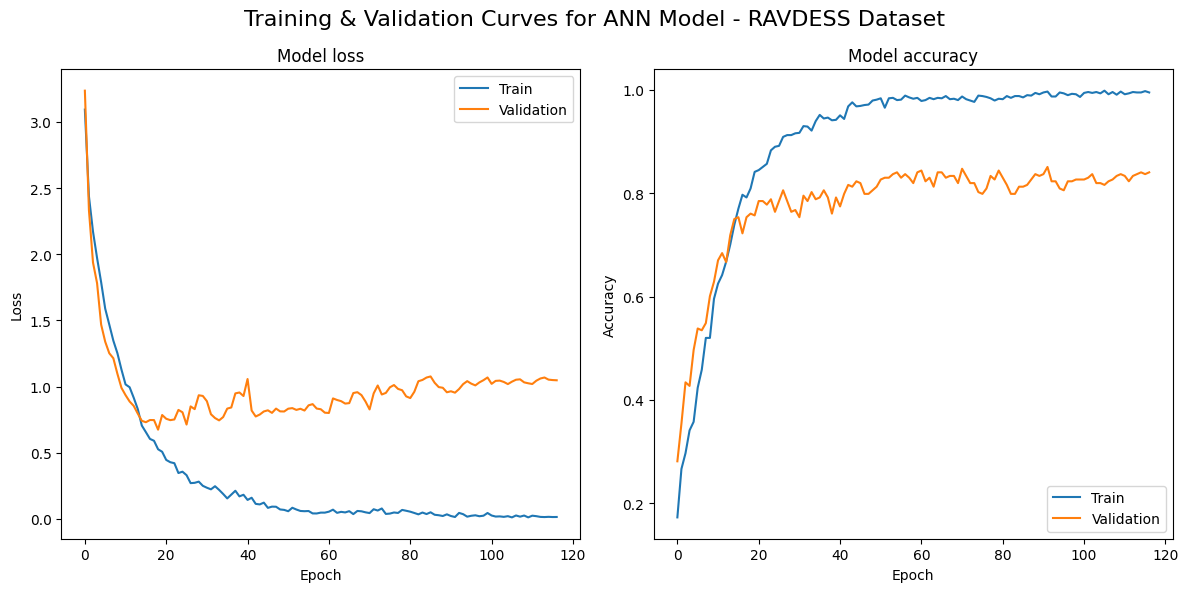

In [ ]:
plot_history(history,'RAVDESS')

In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
trainX, testX, trainY, testY = split_preprocess(rav,rs=200)
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
def build_model(hp):
    model = Sequential()
    reg = hp.Choice('regularizer', ['l2', 'l1', 'l1_l2', 'none'])
    if reg == 'l2':
        kr = regularizers.l2(0.001)
    elif reg == 'l1':
        kr = regularizers.l1(0.001)
    elif reg == 'l1_l2':
        kr = regularizers.l1_l2(l1=0.001, l2=0.001)
    else:
        kr = None
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=256, step=2),
                    activation='relu', input_shape=(trainX.shape[1],),
                    kernel_regularizer=kr))
    model.add(Dropout(hp.Float('dropout_rate_input', min_value=0, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=2),
                        activation='relu', kernel_regularizer=kr))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0, max_value=0.5, step=0.1)))

    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    lr = hp.Float('learning_rate',min_value=0.00001,max_value=0.01,step=0.00001)
    optimizer_dict = {'Adam': Adam(learning_rate=lr),'SGD': SGD(learning_rate=lr),'RMSprop': RMSprop(learning_rate=lr),
                      'Adadelta': Adadelta(learning_rate=lr),'Adagrad': Adagrad(learning_rate=lr),'Adamax': Adamax(learning_rate=lr),
                      'Nadam': Nadam(learning_rate=lr)}
    selected_optimizer = hp.Choice('optimizer', list(optimizer_dict.keys()))
    model.compile(optimizer=optimizer_dict[selected_optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='ann_hyperparam_tuning',
    project_name='ANN_RAVDESS16'
)
callbackshpt = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001)]
tuner.search(trainX, trainY_enc, epochs=500, batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [i for i in range(16,132,4)]),validation_data=(testX, testY_enc),callbacks=callbackshpt)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best trial ID: {best_trial.trial_id}")

Reloading Tuner from ann_hyperparam_tuning/ANN_RAVDESS16/tuner0.json
Best hyperparameters: {'regularizer': 'l1', 'units_input': 178, 'dropout_rate_input': 0.30000000000000004, 'num_layers': 1, 'units_0': 56, 'dropout_rate_0': 0.1, 'learning_rate': 0.00993, 'optimizer': 'SGD', 'batch_size': 112, 'units_1': 48, 'dropout_rate_1': 0.1, 'units_2': 76, 'dropout_rate_2': 0.0}
Best trial ID: 06


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
trials_data = []
for trial in tuner.oracle.trials.values():
    trial_hps = trial.hyperparameters.values.copy()
    val_acc = trial.metrics.get_best_value('val_accuracy')
    trial_hps['val_accuracy'] = val_acc
    trials_data.append(trial_hps)
trials_df = pd.DataFrame(trials_data)
accuracy_column = trials_df.pop('val_accuracy')
trials_df['val_accuracy'] = accuracy_column
trials_df.sort_values(by='val_accuracy', ascending=False, inplace=True)
trials_df

,regularizer,units_input,dropout_rate_input,num_layers,units_0,dropout_rate_0,learning_rate,optimizer,batch_size,units_1,dropout_rate_1,units_2,dropout_rate_2,val_accuracy
23,l1,178,0.3,1,56,0.1,0.00993,SGD,112,48,0.1,76,0.0,0.847222
14,l1,198,0.3,1,132,0.0,0.00013,Nadam,112,188,0.1,138,0.1,0.836806
20,l2,62,0.1,3,68,0.2,0.00453,RMSprop,88,160,0.2,62,0.1,0.829861
9,none,142,0.4,3,58,0.3,0.00087,Nadam,60,16,0.0,16,0.0,0.829861
8,l2,186,0.4,3,254,0.2,0.00895,SGD,40,232,0.1,210,0.4,0.822917
11,l2,174,0.1,1,172,0.3,0.00271,RMSprop,116,186,0.0,30,0.3,0.822917
3,l1_l2,22,0.0,1,48,0.0,0.00136,Adamax,44,242,0.0,40,0.1,0.819444
10,l1,230,0.0,1,184,0.0,0.00227,SGD,36,198,0.3,96,0.3,0.815972
6,l2,228,0.2,3,110,0.3,0.00058,RMSprop,52,180,0.3,122,0.2,0.809028
1,none,150,0.3,1,114,0.1,0.00853,SGD,56,48,0.0,222,0.3,0.809028


In [ ]:
trials_df.to_csv('/content/drive/MyDrive/PBL_2_Files/keras_tuner_trials_data_ann_opensmile_ravdess.csv')

In [ ]:
df_analysis = trials_df.copy()
numerical_features = df_analysis.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df_analysis.select_dtypes(include=['object', 'category'])
correlation_matrix = numerical_features.corrwith(df_analysis['val_accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

units_input           0.113463
dropout_rate_1        0.094169
units_1               0.086245
units_2               0.037427
dropout_rate_2       -0.004637
dropout_rate_0       -0.016867
batch_size           -0.044365
units_0              -0.100211
learning_rate        -0.209882
num_layers           -0.244443
dropout_rate_input   -0.301846
dtype: float64


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in categorical_features:
    model = ols(f'val_accuracy ~ C({col})', data=df_analysis).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA result for {col}:\n", anova_table)

ANOVA result for regularizer:
                   sum_sq    df         F    PR(>F)
C(regularizer)  0.145483   3.0  2.199447  0.112124
Residual        0.573260  26.0       NaN       NaN
ANOVA result for optimizer:
                 sum_sq    df         F    PR(>F)
C(optimizer)  0.190169   6.0  1.379147  0.264811
Residual      0.528574  23.0       NaN       NaN


In [ ]:
trials_enc = pd.get_dummies(trials_df, columns=['optimizer', 'regularizer'])
accuracy_column = trials_enc.pop('val_accuracy')
trials_enc['val_accuracy'] = accuracy_column

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X, y)
y_pred = dt_model.predict(X)
mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
mae = np.mean(np.abs((y - y_pred)))
print(f"Mean Absolute Error: {mae:.2f}")
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Percentage Error: 0.00%
Mean Absolute Error: 0.00
Mean Squared Error: 0.0
R-squared: 1.0


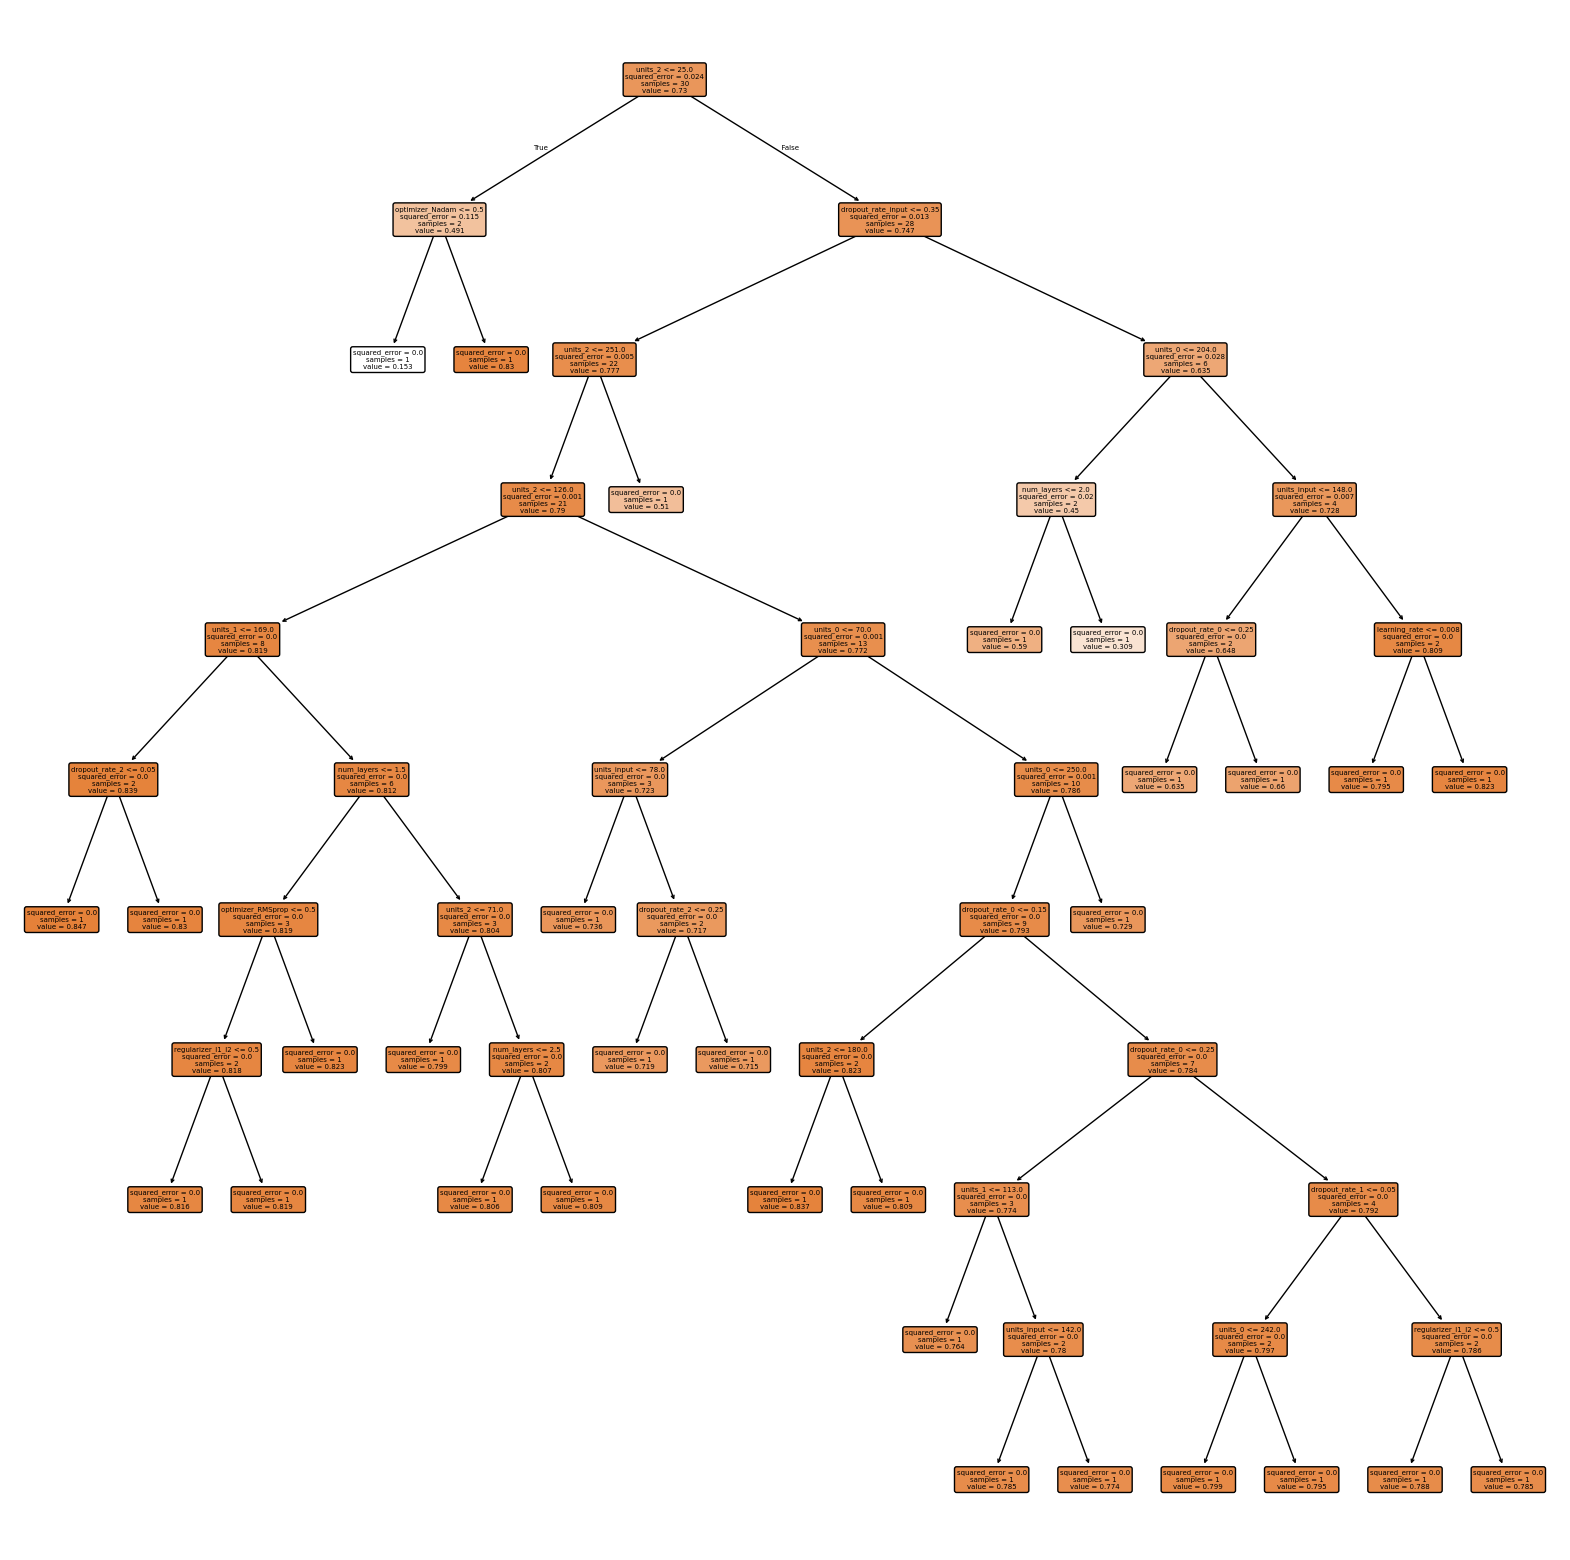

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))
plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True, class_names=['val_accuracy'])
plt.show()

In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
trainX, testX, trainY, testY = split_preprocess(rav,rs=200,apply_smote=True)
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))
def build_model(hp):
    model = Sequential()
    reg = hp.Choice('regularizer', ['none'])
    if reg == 'l2':
        kr = regularizers.l2(0.001)
    elif reg == 'l1':
        kr = regularizers.l1(0.001)
    elif reg == 'l1_l2':
        kr = regularizers.l1_l2(l1=0.001, l2=0.001)
    else:
        kr = None
    model.add(Dense(units=hp.Int('units_input', min_value=100, max_value=300, step=2),
                    activation='relu', input_shape=(trainX.shape[1],),
                    kernel_regularizer=kr))
    model.add(Dropout(hp.Float('dropout_rate_input', min_value=0.5, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 3, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=100, max_value=300, step=2),
                        activation='relu', kernel_regularizer=kr))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.5, max_value=0.5, step=0.1)))

    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    lr = hp.Float('learning_rate',min_value=0.001,max_value=0.005,step=0.00001)
    optimizer_dict = {'Adam': Adam(learning_rate=lr)}
    selected_optimizer = hp.Choice('optimizer', list(optimizer_dict.keys()))
    model.compile(optimizer=optimizer_dict[selected_optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='ann_hyperparam_tuning',
    project_name='ANN_RAVDESS18'
)
callbackshpt = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001)]
tuner.search(trainX, trainY_enc, epochs=500, batch_size=64,validation_data=(testX, testY_enc),callbacks=callbackshpt)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best trial ID: {best_trial.trial_id}")

Trial 30 Complete [00h 00m 44s]
val_accuracy: 0.8125

Best val_accuracy So Far: 0.8402777910232544
Total elapsed time: 00h 21m 26s
Best hyperparameters: {'regularizer': 'none', 'units_input': 246, 'dropout_rate_input': 0.5, 'num_layers': 3, 'units_0': 106, 'dropout_rate_0': 0.5, 'units_1': 162, 'dropout_rate_1': 0.5, 'units_2': 242, 'dropout_rate_2': 0.5, 'learning_rate': 0.0013700000000000001, 'optimizer': 'Adam'}
Best trial ID: 15


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def extract_hyperparameters(model):
    hps = {}
    dl,do = 0,0
    hps['optimizer'] = model.optimizer.get_config()['name']
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            dl+=1
            if dl==1:
                hps['units_input'] = layer.units
            elif layer.units!=8:
                hps[f'units_{dl-2}'] = layer.units
        elif isinstance(layer, tf.keras.layers.Dropout):
            do+=1
            if do==1:
                hps['dropout_rate_input'] = layer.rate
            else:
                hps[f'dropout_rate_{do-2}'] = layer.rate
    return hps
model_path = "/content/drive/MyDrive/PBL_2_Files/Models/best_ann_model_val_acc_85.07_ravdess_opensmile.keras"
model = load_model(model_path)
hps = extract_hyperparameters(model)
print(hps)
print(len(hps))

{'optimizer': 'adam', 'units_input': 128, 'dropout_rate_input': 0.5, 'units_0': 244, 'dropout_rate_0': 0.5, 'units_1': 274, 'dropout_rate_1': 0.5, 'units_2': 112, 'dropout_rate_2': 0.5}
9


In [ ]:
pip install anytree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 756.1 kB/s eta 0:00:00


In [ ]:
import json
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
def visualize_json_as_tree(data, parent=None, root_node=None):
  if isinstance(data, dict):
    if parent is None:
      root_node = Node("Root")
      parent = root_node
    for key, value in data.items():
      new_node = Node(key, parent=parent)
      visualize_json_as_tree(value, parent=new_node)
  elif isinstance(data, list):
    if parent is None:
      root_node = Node("Root")
      parent = root_node
    for i, item in enumerate(data):
      new_node = Node(f"[{i}]", parent=parent)
      visualize_json_as_tree(item, parent=new_node)
  else:
    if parent is not None:
      Node(str(data), parent=parent)
  return root_node
model_config = loaded_model.get_config()
root_node = visualize_json_as_tree(model_config)
for pre, fill, node in RenderTree(root_node):
  print("%s%s" % (pre, node.name))

Root
├── name
│   └── sequential_18
├── trainable
│   └── True
├── dtype
│   ├── module
│   │   └── keras
│   ├── class_name
│   │   └── DTypePolicy
│   ├── config
│   │   └── name
│   │       └── float32
│   └── registered_name
│       └── None
├── layers
│   ├── [0]
│   │   ├── module
│   │   │   └── keras.layers
│   │   ├── class_name
│   │   │   └── InputLayer
│   │   ├── config
│   │   │   ├── batch_shape
│   │   │   │   └── (None, 6373)
│   │   │   ├── dtype
│   │   │   │   └── float32
│   │   │   ├── sparse
│   │   │   │   └── False
│   │   │   └── name
│   │   │       └── input_layer_18
│   │   └── registered_name
│   │       └── None
│   ├── [1]
│   │   ├── module
│   │   │   └── keras.layers
│   │   ├── class_name
│   │   │   └── Dense
│   │   ├── config
│   │   │   ├── name
│   │   │   │   └── dense_92
│   │   │   ├── trainable
│   │   │   │   └── True
│   │   │   ├── dtype
│   │   │   │   ├── module
│   │   │   │   │   └── keras
│   │   │   │   ├── class_name
│   │   │   │ 

In [ ]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load and preprocess dataset
trainX, testX, trainY, testY = split_preprocess(rav,rs=200)
le = LabelEncoder()
trainY_enc = to_categorical(le.fit_transform(trainY))
testY_enc = to_categorical(le.transform(testY))

# HistoryCallback to store all histories
class HistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        # Dictionary to store history for each trial
        self.trial_histories = {}
        self.current_trial_id = None

    def set_trial_id(self, trial_id):
        print("Setting trial id",trial_id)
        self.current_trial_id = trial_id

    def on_train_begin(self, logs=None):
        # Initialize history for the current trial
        print(self.current_trial_id)
        if self.current_trial_id is not None:
            self.trial_histories[self.current_trial_id] = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
            print(self.trial_histories)

    def on_epoch_end(self, epoch, logs=None):
        # Append metrics for each epoch
        print("on epoch end trial id",self.current_trial_id)
        if self.current_trial_id is not None:
            for key, value in logs.items():
                self.trial_histories[self.current_trial_id][key].append(value)
            print(self.trial_histories)
# Model builder function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Regularizer choices
    reg = hp.Choice('regularizer', ['l2', 'l1', 'l1_l2', 'none'])
    if reg == 'l2':
        kr = regularizers.l2(0.001)
    elif reg == 'l1':
        kr = regularizers.l1(0.001)
    elif reg == 'l1_l2':
        kr = regularizers.l1_l2(l1=0.001, l2=0.001)
    else:
        kr = None

    # Input layer
    model.add(Dense(units=hp.Int('units_input', min_value=16, max_value=256, step=2),
                    activation='relu', input_shape=(trainX.shape[1],),
                    kernel_regularizer=kr))
    model.add(Dropout(hp.Float('dropout_rate_input', min_value=0, max_value=0.5, step=0.1)))

    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=256, step=2),
                        activation='relu', kernel_regularizer=kr))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))

    # Optimizer choices
    lr = hp.Float('learning_rate', min_value=0.00001, max_value=0.01, step=0.00001)
    optimizer_dict = {
        'Adam': Adam(learning_rate=lr),
        'SGD': SGD(learning_rate=lr),
        'RMSprop': RMSprop(learning_rate=lr),
        'Adadelta': Adadelta(learning_rate=lr),
        'Adagrad': Adagrad(learning_rate=lr),
        'Adamax': Adamax(learning_rate=lr),
        'Nadam': Nadam(learning_rate=lr)
    }
    selected_optimizer = hp.Choice('optimizer', list(optimizer_dict.keys()))

    model.compile(optimizer=optimizer_dict[selected_optimizer],
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to patch the tuner and track trial IDs
class CustomTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        history_callback.set_trial_id(trial.trial_id)  # Set trial ID for the history callback
        res = super().run_trial(trial, *args, **kwargs)
        return res

# Create HistoryCallback instance
history_callback = HistoryCallback()

# Initialize KerasTuner RandomSearch
tuner = CustomTuner(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    directory='ann_hyperparam_tuning',
    project_name='ANN_RAVDESS15'
)


# Early stopping and learning rate scheduler callbacks
callbackshpt = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001)
]

# Start hyperparameter search
tuner.search(trainX, trainY_enc,
             epochs=50,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [i for i in range(16, 132, 4)]),
             validation_data=(testX, testY_enc),
             callbacks=[history_callback] + callbackshpt)

# Retrieve the best trial ID
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial_id = best_trial.trial_id

# Access the history for the best trial
print(history_callback.trial_histories)
best_trial_history = history_callback.trial_histories[int(best_trial_id)]

# Plot the training and validation accuracy for the best trial
plt.plot(best_trial_history['accuracy'])
plt.plot(best_trial_history['val_accuracy'])
plt.title('Model Accuracy of Best Trial')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss for the best trial
plt.plot(best_trial_history['loss'])
plt.plot(best_trial_history['val_loss'])
plt.title('Model Loss of Best Trial')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"Best trial ID: {best_trial.trial_id}")

Trial 1 Complete [00h 00m 58s]
val_accuracy: 0.6631944179534912

Best val_accuracy So Far: 0.6631944179534912
Total elapsed time: 00h 00m 58s
{}


KeyError: 0